# Twitter Analysis

In [4]:
import json
import pandas as pd
from textblob import TextBlob
import re
import seaborn as sns
import collections
from matplotlib import pyplot as plt
import time
from datetime import datetime
from nltk.tokenize import TweetTokenizer

In [92]:
import warnings
warnings.filterwarnings('ignore')

### Functions

In [35]:
def convertdate(datstr):
    return time.mktime(datetime.strptime(datstr, '%m/%d/%Y %H:%M').timetuple())
# print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [36]:
def clean_tweet(tweet): 
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 
  

In [37]:
def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

In [38]:
def get_tweet_win(tweet):
    if 'win' in tweet:
        return 1
    else:
        return 0

In [39]:
def get_tweet_choose(tweet):
    if 'choose' in tweet:
        return 1
    else:
        return 0

In [40]:
def counttweet(df,name):
    total = None

    total = df[df['text'].str.contains(name)].text.count()
    return total

In [41]:
def counttweet(df,name):
    total = None
    win = None
    choose = None
    
    total = df[df['text'].str.contains(name)].text.count()
    win = df[df['text'].str.contains(name)].win.sum()
    choose = df[df['text'].str.contains(name)].choose.sum()
    return [total,win,choose]

In [42]:
def countsent(df,name):
    pos = None
    neutral = None
    neg = None
    try:
        pos = df[df['text'].str.contains(name)].groupby('sentiment').text.count().positive
        neutral = df[df['text'].str.contains(name)].groupby('sentiment').text.count().neutral
        neg = df[df['text'].str.contains(name)].groupby('sentiment').text.count().negative
    except:
        aggsent = df[df['text'].str.contains(name)].groupby('sentiment').agg('count').text
        if len(aggsent.index) == 2:
            sent0 = aggsent.index[0]
            sent1 = aggsent.index[1]
            if sent0 == 'positive' or sent1 == 'positive':
                pos = df[df['text'].str.contains(name)].groupby('sentiment').text.count().positive
            else:
                pos = 0
            if sent0 == 'negative' or sent1 == 'negative':
                neg = df[df['text'].str.contains(name)].groupby('sentiment').text.count().negative
            else:
                neg = 0
            if sent0 == 'neutral' or sent1 == 'neutral':
                neutral = df[df['text'].str.contains(name)].groupby('sentiment').text.count().neutral
            else:
                neutral = 0
    return [pos,neutral,neg]

In [43]:
def wordcount(df):
    data = df['text'].tolist()
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    wordlists = []
    for ea in range(0,len(data)):
        wordlists.append(tknzr.tokenize(data[ea]['text']))
    wordlist = [item for sublist in wordlists for item in sublist]
    return wordlist

In [93]:
def dataread(files):
    #read twitter data from json files
    ettedata = []
    for file in files:
        with open(file) as tweetfile:
            for ea in tweetfile.readlines():
        #         print(ea)
                ettedata.append(json.loads(ea))
    
    #convert twitter data to pandas dataframe
    ettedf = pd.DataFrame(ettedata, columns=['user', 'timestamp_ms', 'id','retweet_count','text'])
    ettedf['timestamp_ms'] = pd.to_numeric(ettedf['timestamp_ms'])
    
    #get sentiments, win&choose indicators
    ettedf['sentiment'] = ettedf.apply(lambda x: get_tweet_sentiment(x.text), axis=1)
    ettedf['win'] = ettedf.apply(lambda x: get_tweet_win(x.text), axis=1)
    ettedf['choose'] = ettedf.apply(lambda x: get_tweet_choose(x.text), axis=1)
    
    return ettedf

In [94]:
def computeweek(season,data,contdf,week):
    showall = pd.read_csv('ette_showtimes.csv') #make this global??
    show = showall[showall['Season'] == season]
    
    w1 = convertdate(show[show.Week == (week-1)].Airing.values[0])*1000
    w2 = convertdate(show[show.Week == week].Airing.values[0])*1000
    seasondata = data[(data['timestamp_ms'] > w1) & (data['timestamp_ms'] < w2)]

    total = str(week) + '-Total'
    pos = str(week) + '-Positive'
    neutral = str(week) + '-Neutral'
    neg = str(week) + '-Negative'
    win = str(week) + '-win'
    choose = str(week) + '-choose'
    contdf[[total,win,choose]] = pd.DataFrame(contdf.apply(lambda x: counttweet(seasondata,x['firstname']),axis=1).tolist(), index = contdf.index)
    contdf[[pos,neutral,neg]] = pd.DataFrame(contdf.apply(lambda x: countsent(seasondata,x['firstname']),axis=1).tolist(), index = contdf.index)
    return contdf
    

## Contestants

Problem here in that we don't keep the first name, last initial when needed?

In [95]:
cont = pd.read_csv('bachelorette-contestants.csv')

In [96]:
cont['firstname'] = cont['Name'].str.split().tolist()
cont['firstname'] = cont['firstname'].apply(lambda x: x[0])

In [97]:
cont.head()

,Name,Age,Occupation,Hometown,ElimWeek,Season,firstname
0,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1,Ryan
1,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1,Charlie
2,Russ,30,Writer,"San Rafael, California",5.0,1,Russ
3,Greg T.,28,Importer,"Manhattan, New York",4.0,1,Greg
4,Bob Guiney,31,Mortgage Broker,"Ferndale, Michigan",3.0,1,Bob


## Season Showtimes

In [98]:
showtimes = pd.read_csv('ette_showtimes.csv')

## Get Features from Data

In [99]:
contdf12 = cont[cont['Season']==12]
tw_files12 = ['TwitterData/2016/201605','TwitterData/2016/201606','TwitterData/2016/201607','TwitterData/2016/201608'] #12
ettedf12 = dataread(tw_files12)
for week in showtimes[showtimes['Season']== 12]['Week'][1:]:
    ette12_twitterfeatures = computeweek(12,ettedf12,contdf12,week)

ette12_twitterfeatures.head()

,Name,Age,Occupation,Hometown,ElimWeek,Season,firstname,2.0-Total,2.0-win,2.0-choose,...,10.0-choose,10.0-Positive,10.0-Neutral,10.0-Negative,11.0-Total,11.0-win,11.0-choose,11.0-Positive,11.0-Neutral,11.0-Negative
256,Jordan Rodgers,27,Former Pro Quarterback,"Chico, California",NaN,12,Jordan,2762,250,3,...,17,914.0,775.0,457.0,507,13,67,171.0,290.0,46.0
257,Robby Hayes,27,Former Competitive Swimmer,"St. Augustine, Florida",10.0,12,Robby,146,38,0,...,11,1069.0,700.0,429.0,523,56,63,164.0,313.0,46.0
258,Chase McNary,27,Medical Sales Rep,"Castle Rock, Colorado",9.0,12,Chase,79,1,0,...,6,2215.0,1511.0,1043.0,668,7,1,246.0,173.0,249.0
259,Luke Pell,31,War Veteran,"Burnet, Texas",8.0,12,Luke,996,67,6,...,17,1424.0,1535.0,627.0,1213,16,5,623.0,435.0,155.0
260,James Taylor,29,Singer-Songwriter,"Katy, Texas",7.0,12,James,421,20,1,...,0,11.0,11.0,3.0,51,0,0,31.0,16.0,4.0


In [100]:
contdf11 = cont[cont['Season']==11]
tw_files11 = ['TwitterData/2015/201505','TwitterData/2015/201506','TwitterData/2015/201507'] #11
ettedf11 = dataread(tw_files11)
for week in showtimes[showtimes['Season']== 11]['Week'][1:]:
    ette11_twitterfeatures = computeweek(11,ettedf11,contdf11,week)

ette11_twitterfeatures.head()

,Name,Age,Occupation,Hometown,ElimWeek,Season,firstname,2.0-Total,2.0-win,2.0-choose,...,11.0-choose,11.0-Positive,11.0-Neutral,11.0-Negative,12.0-Total,12.0-win,12.0-choose,12.0-Positive,12.0-Neutral,12.0-Negative
230,Shawn Booth,28,Personal Trainer,"Windsor Locks, Connecticut",NaN,11,Shawn,0,0,0,...,4,421.0,378.0,205.0,277,12,7,213.0,49.0,15.0
231,Nick Viall,34,Software Sales Executive,"Waukesha, Wisconsin",9.0,11,Nick,0,0,0,...,12,523.0,502.0,292.0,198,11,8,79.0,92.0,27.0
232,Ben Higgins,26,Software Salesman,"Warsaw, Indiana",8.0,11,Ben,0,0,0,...,14,811.0,948.0,211.0,1047,6,2,515.0,427.0,105.0
233,Jared Haibon,26,Restaurant Manager,"Warwick, Rhode Island",7.0,11,Jared,0,0,0,...,0,12.0,9.0,2.0,300,4,0,74.0,199.0,27.0
234,Joe Bailey,28,Insurance Agent,"Glasgow, Kentucky",7.0,11,Joe,0,0,0,...,0,4.0,2.0,0.0,18,0,0,12.0,4.0,2.0


In [101]:
contdf13 = pd.DataFrame(['Peter','Josiah','Bryan','Kenny','Rob','Iggy','Bryce','Will','Diggy',\
                           'Kyle','Blake K.','Brady','Dean','Eric','DeMario','Blake E.','Fred',\
                           'Jonathan','Lee','Alex','Milton','Adam','Matt','Grant','Anthony','Jamey',\
                           'Jack Stone','Mohit','Jedidiah','Michael','Lucas'])
contdf13.columns = (['firstname'])

tw_files13 = ['TwitterData/2017/05','TwitterData/2017/06','TwitterData/2017/07','TwitterData/2017/08'] #13
ettedf13 = dataread(tw_files13)
for week in showtimes[showtimes['Season']== 13]['Week'][1:]:
    ette13_twitterfeatures = computeweek(13,ettedf13,contdf13,week)

ette13_twitterfeatures.head()

,firstname,2.0-Total,2.0-win,2.0-choose,2.0-Positive,2.0-Neutral,2.0-Negative,3.0-Total,3.0-win,3.0-choose,...,10.0-choose,10.0-Positive,10.0-Neutral,10.0-Negative,11.0-Total,11.0-win,11.0-choose,11.0-Positive,11.0-Neutral,11.0-Negative
0,Peter,38,3,0,17.0,21.0,0.0,70,2,0,...,2,55.0,61.0,22.0,17,3,0,9.0,5.0,3.0
1,Josiah,50,0,0,14.0,31.0,5.0,9,0,0,...,0,NaN,NaN,NaN,2,0,0,NaN,NaN,NaN
2,Bryan,40,0,1,19.0,16.0,5.0,7,0,0,...,2,37.0,58.0,37.0,10,1,0,4.0,5.0,1.0
3,Kenny,11,0,0,6.0,5.0,0.0,11,3,0,...,0,NaN,NaN,NaN,22,0,0,8.0,11.0,3.0
4,Rob,4,0,0,0.0,2.0,2.0,0,0,0,...,0,NaN,NaN,NaN,1,0,0,1.0,NaN,NaN


In [103]:
contdf14 = pd.DataFrame(['Colton','Grant','Clay','Jean Blanc','Connor','Joe','John','Leo',\
                           'Jordan','Rickey','Alex','Nick','Mike','Garrett','Blake','Lincoln',\
                           'Chase','Darius','Ryan','Christon','Wills','Jason','Kamil','Jake','Trent',\
                           'Christian','David','Chris'])
contdf14.columns = (['firstname'])

tw_files14 = ['TwitterData/2018/05','TwitterData/2018/06','TwitterData/2018/07','TwitterData/2018/08'] #14
ettedf14 = dataread(tw_files14)
for week in showtimes[showtimes['Season']== 14]['Week'][1:]:
    ette14_twitterfeatures = computeweek(14,ettedf14,contdf14,week)

ette14_twitterfeatures.head()

,firstname,2.0-Total,2.0-win,2.0-choose,2.0-Positive,2.0-Neutral,2.0-Negative,3.0-Total,3.0-win,3.0-choose,...,10.0-choose,10.0-Positive,10.0-Neutral,10.0-Negative,11.0-Total,11.0-win,11.0-choose,11.0-Positive,11.0-Neutral,11.0-Negative
0,Colton,656,34,4,231,392.0,33.0,224,0,2,...,0,16.0,21.0,21.0,160,3,0,54.0,84.0,22.0
1,Grant,11,0,0,3,6.0,2.0,0,0,0,...,0,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN
2,Clay,99,0,0,45,35.0,19.0,47,2,0,...,0,1.0,2.0,0.0,10,0,0,1.0,6.0,3.0
3,Jean Blanc,28,3,0,12,10.0,6.0,11,1,0,...,0,NaN,NaN,NaN,29,0,0,7.0,17.0,5.0
4,Connor,27,0,0,15,9.0,3.0,117,11,1,...,0,NaN,NaN,NaN,30,0,0,7.0,23.0,0.0


In [108]:
ette14_twitterfeatures['Season'] = 14
ette13_twitterfeatures['Season'] = 13

In [109]:
c = pd.concat([ette14_twitterfeatures,ette13_twitterfeatures, ette12_twitterfeatures,ette11_twitterfeatures],ignore_index=True)

In [111]:
c.to_csv('twitterfeatures.csv', index=False)

## Extra Stuff

### Read Twitter Data

In [3]:
data = []
with open('tweet_sample.2016-1-1.txt') as tweetfile:
    for ea in tweetfile.readlines():
#         print(ea)
        data.append(json.loads(ea))

In [361]:
len(ettedata)

9940

In [362]:
print(ettedata[0].keys())

dict_keys(['contributors', 'truncated', 'text', 'is_quote_status', 'in_reply_to_status_id', 'id', 'favorite_count', 'source', 'retweeted', 'coordinates', 'timestamp_ms', 'entities', 'in_reply_to_screen_name', 'id_str', 'display_text_range', 'retweet_count', 'in_reply_to_user_id', 'favorited', 'user', 'geo', 'in_reply_to_user_id_str', 'possibly_sensitive', 'lang', 'created_at', 'filter_level', 'in_reply_to_status_id_str', 'place', 'extended_entities'])


### Convert to Dataframe

In [87]:
ettedf = pd.DataFrame(ettedata, columns=['user', 'timestamp_ms', 'id','retweet_count','text'])
ettedf['timestamp_ms'] = pd.to_numeric(ettedf['timestamp_ms'])

### Get Sentiments, Win&Choose indicators

In [88]:
ettedf['sentiment'] = ettedf.apply(lambda x: get_tweet_sentiment(x.text), axis=1)
ettedf['win'] = ettedf.apply(lambda x: get_tweet_win(x.text), axis=1)
ettedf['choose'] = ettedf.apply(lambda x: get_tweet_choose(x.text), axis=1)

## Select Season 14 Bachelorette Data

In [78]:
ettedata14 = []
for i in range(0,len(ettedata)):
    time = int(ettedata[i]['timestamp_ms'])
    if (time > 1527552000000 and time < 1533686400000):
        ettedata14.append(ettedata[i])

In [79]:
print(len(ettedata))
print(len(ettedata14))

57329
55185


In [210]:
ettedf14 = pd.DataFrame(ettedata14, columns=['user', 'timestamp_ms', 'id','retweet_count','text'])
ettedf14['timestamp_ms'] = pd.to_numeric(ettedf14['timestamp_ms'])
ettedf14.head()

,user,timestamp_ms,id,retweet_count,text
0,"{'follow_request_sent': None, 'listed_count': ...",1527552006201,1001251800274550785,0,#TheBachelorette Waka waka waka waka waka waka...
1,"{'follow_request_sent': None, 'listed_count': ...",1527552021702,1001251865290575873,0,#TheBachelorette is about to start so brace yo...
2,"{'follow_request_sent': None, 'listed_count': ...",1527552023402,1001251872420913152,0,"RT @clmgiudici: Hey @thebkoof, I cannot wait t..."
3,"{'follow_request_sent': None, 'listed_count': ...",1527552031206,1001251905153138688,0,Lets do the damn thing! Hopefully we wont hear...
4,"{'follow_request_sent': None, 'listed_count': ...",1527552033502,1001251914783207424,0,RT @monicachummy: IT’S BACHELORETTE MONDAY #Th...


In [315]:
ettedf14['sentiment'] = ettedf14.apply(lambda x: get_tweet_sentiment(x.text), axis=1)
ettedf14['win'] = ettedf14.apply(lambda x: get_tweet_win(x.text), axis=1)
ettedf14['choose'] = ettedf14.apply(lambda x: get_tweet_choose(x.text), axis=1)
ettedf14.head()

,user,timestamp_ms,id,retweet_count,text,sentiment,win,choose
0,"{'follow_request_sent': None, 'listed_count': ...",1527552006201,1001251800274550785,0,#TheBachelorette Waka waka waka waka waka waka...,neutral,0,0
1,"{'follow_request_sent': None, 'listed_count': ...",1527552021702,1001251865290575873,0,#TheBachelorette is about to start so brace yo...,positive,0,0
2,"{'follow_request_sent': None, 'listed_count': ...",1527552023402,1001251872420913152,0,"RT @clmgiudici: Hey @thebkoof, I cannot wait t...",neutral,0,0
3,"{'follow_request_sent': None, 'listed_count': ...",1527552031206,1001251905153138688,0,Lets do the damn thing! Hopefully we wont hear...,neutral,0,0
4,"{'follow_request_sent': None, 'listed_count': ...",1527552033502,1001251914783207424,0,RT @monicachummy: IT’S BACHELORETTE MONDAY #Th...,neutral,0,0


## Season 13 Bachelorette Contestants

In [358]:
ette13cont = pd.DataFrame(['Peter','Josiah','Bryan','Kenny','Rob','Iggy','Bryce','Will','Diggy',\
                           'Kyle','Blake K.','Brady','Dean','Eric','DeMario','Blake E.','Fred',\
                           'Jonathan','Lee','Alex','Milton','Adam','Matt','Grant','Anthony','Jamey',\
                           'Jack Stone','Mohit','Jedidiah','Michael','Lucas'])
ette13cont.columns = (['Name'])
ette13cont.head()


,Name
0,Peter
1,Josiah
2,Bryan
3,Kenny
4,Rob


## Season 14 Bachelorette Contestants

In [292]:
ette14cont = pd.DataFrame(['Colton','Grant','Clay','Jean Blanc','Connor','Joe','John','Leo','Jordan','Rickey','Alex','Nick','Mike','Garrett','Blake','Lincoln','Chase','Darius','Ryan','Christon','Wills','Jason','Kamil','Jake','Trent','Christian','David','Chris'])
ette14cont.columns = (['Name'])
ette14cont.head()


,Name
0,Colton
1,Grant
2,Clay
3,Jean Blanc
4,Connor


In [348]:
for week in ette14show['Week'][1:]:
    ette14_twitterfeatures = computeweek(ettedf14,ette14cont,week)
ette14_twitterfeatures['Season'] = 14

In [347]:
ette14_twitterfeatures.to_csv('ette14_twitterfeatures.csv',index=False)

In [367]:
for week in ette13show['Week'][1:]:
    ette13_twitterfeatures = computeweek(ettedf,ette13cont,week)
ette13_twitterfeatures['Season'] = 13

In [368]:
ette13_twitterfeatures

,Name,2-Total,2-win,2-choose,2-Positive,2-Neutral,2-Negative,3-Total,3-win,3-choose,...,10-Positive,10-Neutral,10-Negative,11-Total,11-win,11-choose,11-Positive,11-Neutral,11-Negative,Season
0,Peter,38,3,0,17.0,21.0,0.0,70,2,0,...,55.0,61.0,22.0,17,3,0,9.0,5.0,3.0,13
1,Josiah,50,0,0,14.0,31.0,5.0,9,0,0,...,NaN,NaN,NaN,2,0,0,NaN,NaN,NaN,13
2,Bryan,40,0,1,19.0,16.0,5.0,7,0,0,...,37.0,58.0,37.0,10,1,0,4.0,5.0,1.0,13
3,Kenny,11,0,0,6.0,5.0,0.0,11,3,0,...,NaN,NaN,NaN,22,0,0,8.0,11.0,3.0,13
4,Rob,4,0,0,0.0,2.0,2.0,0,0,0,...,NaN,NaN,NaN,1,0,0,1.0,NaN,NaN,13
5,Iggy,4,0,0,0.0,3.0,1.0,1,0,0,...,NaN,NaN,NaN,2,0,0,2.0,NaN,NaN,13
6,Bryce,3,0,0,0.0,2.0,1.0,0,0,0,...,NaN,NaN,NaN,1,0,0,1.0,NaN,NaN,13
7,Will,10,0,0,4.0,5.0,1.0,2,0,0,...,7.0,7.0,1.0,15,0,0,3.0,12.0,0.0,13
8,Diggy,6,0,0,3.0,3.0,0.0,4,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,13
9,Kyle,0,0,0,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,13


In [365]:
# for i in range(0,len(data)):
for i in range(0,25):
    print(ettedata[i]['text'])
    print('---')

The Bachelor NZ, live: Could there be more than one girl going home tonight? https://t.co/tYnZ5TsrWL https://t.co/63PrFLsluP
---
RT @FourPrivetDr: Fans of #TheBachelor and #TheBachelorette - WE NEED YOUR VOTES for @viallnicholas28 and @PetaMurgatroyd! #dwts… 
---
*sees Daniel from #TheBachelor at the gym* 
*tries to stealthily take a Snapchat without looking like a stalker*
*fails*
---
The Bachelor is fresh and delicious. Stop by @SocieteBrewing tonight and help support @LupusSoCal with every glass.… https://t.co/C3EdEru0XB
---
@mrcbishop The results...after the break. This isn't reality TV. This is real life. $AMLH #TheBachelorette
---
#TheBachelor: 16 Shocking Details About #ChrisSoules Fatal Accident https://t.co/rpFmToD4QP https://t.co/8WiQVi8Wju
---
RT @karenrj866: https://t.co/K6Ds7x7Guz
ISN'T THAT LOVE
#TheBachelor #countrymusic #Romance #fashion #gamedev #KeithUrban… 
---
RT @TheEllenShow: My Bachelor recap show got to grill Nick and Vanessa on just how engaged they really are.

In [15]:
#https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

In [29]:
sentiment = []
for i in range(0,len(data)):
    sentiment.append(get_tweet_sentiment(data[i]['text']))

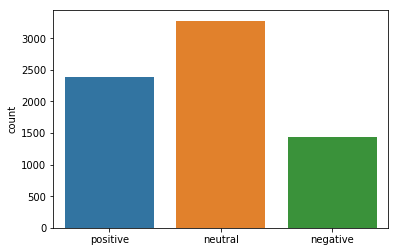

In [30]:
sns.countplot(sentiment)
plt.savefig('sentimentexample')

In [9]:
sentiment[88]

'positive'

In [32]:
cts = collections.Counter(wordlist)

In [33]:
cts.most_common(25)

[('#TheBachelor', 6995),
 (':', 5146),
 ('RT', 3765),
 ('.', 2975),
 ('the', 2509),
 ('I', 2123),
 ('to', 1970),
 ('’', 1808),
 ('?', 1652),
 (',', 1637),
 ('you', 1549),
 ('!', 1442),
 ('Arie', 1426),
 ('is', 1316),
 ('a', 1295),
 ('and', 1198),
 ('"', 960),
 ('s', 859),
 ('in', 845),
 ('…', 843),
 ('of', 831),
 ('Ross', 778),
 ('“', 772),
 ('Becca', 760),
 ('”', 760)]